### Reduced Test Case (Smaller Test Case)

### Importing Relevant Libraries

In [1]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

### Smaller Instance Generation (Random Modelling of Problem)

In [2]:
# Set random seed for reproducibility
random.seed(2)
np.random.seed(2)

# Setting Problem size
nbrblood = 3
nbrcoll = 15
nbrprivh = 3
nbrpubh = 4

# Generate random coordinates for collection centers, blood banks, and hospitals
# Coordinates are normalised to the same range as original data
x_coordCC = np.random.uniform(103, 104, nbrcoll)
y_coordCC = np.random.uniform(1.2, 1.5, nbrcoll)
x_coordBB = np.random.uniform(103, 104, nbrblood)
y_coordBB = np.random.uniform(1.2, 1.5, nbrblood)
x_coord_privhosp = np.random.uniform(103, 104, nbrprivh)
y_coord_privhosp = np.random.uniform(1.2, 1.5, nbrprivh)
x_coord_pubhosp = np.random.uniform(103, 104, nbrpubh)
y_coord_pubhosp = np.random.uniform(1.2, 1.5, nbrpubh)

# Radius of earth
R = 6371

def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# distance calculations between CC and BBs
distancelct=np.empty([nbrblood, nbrcoll])
for i_index in range(nbrblood):
    for j_index in range(nbrcoll):
        d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
        d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
        a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
        c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
        distancelct[i_index,j_index] = R*c

print(distancelct)

# Distance calculation between BBs and private hospitals
distanceBB_priv = np.empty((nbrblood, nbrprivh))

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrprivh):  # loop over private hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_privhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_privhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_privhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_priv[i_index, h_index] = R * c


distanceBB_pub = np.empty((nbrblood, nbrpubh)) # Distance calculation between BBs and public hospitals

for i_index in range(nbrblood):  # loop over blood banks
    for h_index in range(nbrpubh):  # loop over public hospitals
        d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_pubhosp[h_index])
        d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_pubhosp[h_index])
        a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_pubhosp[h_index])) * np.sin(d_lon / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distanceBB_pub[i_index, h_index] = R * c

# Generate random blood collection amounts and capacities
cc_blood = pd.read_csv('community_centres_with_blood_collection.csv')['Amount of Blood Collected']
q_c = cc_blood.sample(n=nbrcoll, replace=True, random_state=42).to_numpy()  # Amount of blood collected at each collection center
g_b = [50, 60, 70] # Min capacity at each blood bank (data taken from original code)
q_b = [100, 120, 130]  # Max capacity at each blood bank (data taken from original code)

# Prepare coordinates for plotting and TSP
comm_coords = list(zip(x_coordCC, y_coordCC))
bank_coords = list(zip(x_coordBB, y_coordBB))
privhosp_coords = list(zip(x_coord_privhosp, y_coord_privhosp))
pubhosp_coords = list(zip(x_coord_pubhosp, y_coord_pubhosp))

[[10.11659213 16.72744037  2.15902337 12.15457231 13.5133439   3.61818486
  15.48470932  4.34964981 13.60112448 12.94784728  5.5069455   8.72167088
  15.16830987  8.8455113   8.51400768]
 [11.10442034 12.45028302  8.95637377 12.86229892 15.26046855  3.28113132
  14.67625509 11.06933533 13.86030304 12.72042194 11.23759142 12.55264238
  13.3948678  12.43004877  5.20282063]
 [14.3168427  22.15679164  4.29508994 16.23643932 11.73943527  8.95681155
  15.54257853  1.48267571 13.10357142 12.97908767  7.01855958  6.10299143
  16.02311853  6.46846793 11.8236622 ]]


Plotting of Randomised Geospatial Data

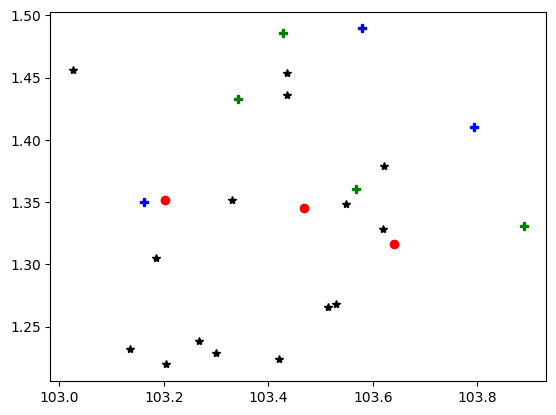

In [3]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green')

## Gurobi Optimisation of Randomised Small-scale Model +
Plotting of Optimality Convergence for Small-scale Benchmarking


Set parameter Username
Set parameter LicenseID to value 2668971


Academic license - for non-commercial use only - expires 2026-05-21
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 9 185H, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 22 logical processors, using up to 22 threads

Non-default parameters:
TimeLimit  3600

Optimize a model with 733 rows, 789 columns and 3342 nonzeros
Model fingerprint: 0x762d6897
Variable types: 45 continuous, 744 integer (744 binary)
Coefficient statistics:
  Matrix range     [4e-01, 8e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 1e+04]
Presolve removed 97 rows and 87 columns
Presolve time: 0.05s
Presolved: 636 rows, 702 columns, 3018 nonzeros
Variable types: 42 continuous, 660 integer (660 binary)
Found heuristic solution: objective 155.0583867

Root relaxation: objective 1.321373e+02, 80 iterations, 0.00 seconds (0.00 work units)

    N

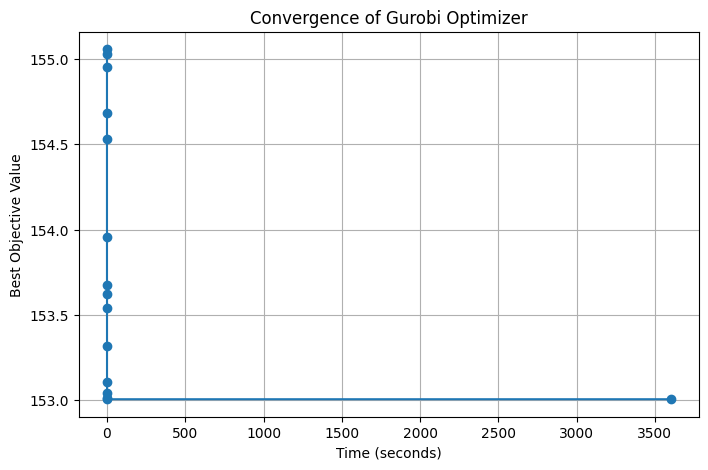

In [ ]:
#Create Model
model = gp.Model("P_Median_and_TSP")

I = list(range(nbrblood)) #Open blood banks  
J = list(range(nbrcoll)) #Collection Centres to be served
H_priv = list(range(nbrprivh)) # Private Hospitals                   
H_pub = list(range(nbrprivh, nbrprivh + nbrpubh))  # Public Hospitals      
H = H_priv + H_pub   # Total Hospitals                                    

 # Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open
z = model.addVars(I, H, vtype=GRB.BINARY, name="deliver") # Deliver from blood banks to hospitals

# Each collection centre j must be assigned to exactly one blood bank i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")

# The demand from blood bank i can only be assigned to an open collection centre j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")

model.addConstr(gp.quicksum(q_c[j] * x[i, j] for i in I for j in J) >= 0.9*328*0.25, name="lower_bound_sum") # Lower bound on total blood collected
# model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 328*2, name="upper_bound_sum") #Upper bound not needed in this case, assume that each blood bank has infinite capacity
model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank

# Fuel cost constraints
f_bc = 0.094*2.61   # Cost per km for blood collection (in SGD)
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 10000, name="budget_constraint") # Fuel cost constraint for blood collection

# Add constraints for blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for i in I) == 1 for h in H), name="deliver_once")  # Each hospital must receive blood from exactly one bank
model.addConstrs((z[i, h] <= y[i] for i in I for h in H), name="only_open_delivery")  # Blood can only be delivered from open banks 

# Add constraints for minimum blood required at each bank
model.addConstrs((gp.quicksum(z[i, h] for h in H) >= 1 for i in I), name="min_blood_required")  # Minimum blood required at each bank

# Add binary variables for TSP routes
# u[k, i, j] = 1 if blood bank k travels from collection center
u = model.addVars(nbrblood, nbrcoll, nbrcoll, vtype=GRB.BINARY, name="route")
for k in range(nbrblood):
    for i in range(nbrcoll):
        model.addConstr(gp.quicksum(u[k, i, j] for j in range(nbrcoll) if j != i) == x[k, i])
        model.addConstr(gp.quicksum(u[k, j, i] for j in range(nbrcoll) if j != i) == x[k, i])

# Add continuous variables for MTZ
mtz = model.addVars(nbrblood, nbrcoll, vtype=GRB.CONTINUOUS, lb=0, ub=nbrcoll, name="mtz")
# Add MTZ constraints to prevent subtours
for k in range(nbrblood):
    for i in range(1, nbrcoll):
        for j in range(1, nbrcoll):
            if i != j:
                model.addConstr(mtz[k, i] - mtz[k, j] + nbrcoll * u[k, i, j] <= nbrcoll - 1)

# Each blood bank to have at least one collection center assigned (this is optional, makes the problem significantly more complex)
# model.addConstrs((gp.quicksum(x[i, j] for j in J) >= 1 for i in I), name="min_one_cc_per_bank")

# Objective function: Minimize the total distance traveled
# The objective is to minimize the total distance traveled by the blood banks and the delivery to hospitals
model.setObjective(
    gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J) +
    # gp.quicksum(z[i, h] * distanceBB_priv[i][h] for i in I for h in H_priv) +
    # gp.quicksum(z[i, h] * distanceBB_pub[i][h - nbrprivh] for i in I for h in H_pub)+
    gp.quicksum(u[k, i, j] * np.linalg.norm(np.array(comm_coords[i]) - np.array(comm_coords[j]))
               for k in range(nbrblood) for i in range(nbrcoll) for j in range(nbrcoll) if i != j),
    GRB.MINIMIZE
)
model.setParam('TimeLimit', 3600)  # 3600 seconds = 60 minutes

convergence_times = []
convergence_objs = []

def convergence_callback(model, where):
    if where == gp.GRB.Callback.MIPSOL:
        time = model.cbGet(gp.GRB.Callback.RUNTIME)
        obj = model.cbGet(gp.GRB.Callback.MIPSOL_OBJ)
        convergence_times.append(time)
        convergence_objs.append(obj)

# When calling optimize, pass the callback:
model.optimize(convergence_callback)

if model.status in [gp.GRB.OPTIMAL, gp.GRB.TIME_LIMIT, gp.GRB.SUBOPTIMAL]:
    print(f"Best objective value found: {model.objVal}")

    assignments = {i: [] for i in I}
    for i in I:
        for j in J:
            if x[i, j].X > 0.5:
                assignments[i].append(j)

    
    plt.figure(figsize=(8, 5))
    plt.plot(convergence_times, convergence_objs, marker='o')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Best Objective Value')
    plt.title('Convergence of Gurobi Optimizer')
    plt.grid(True)
    plt.show()

else:
    print("No feasible solution found. Skipping plotting.")

Solution Plotting

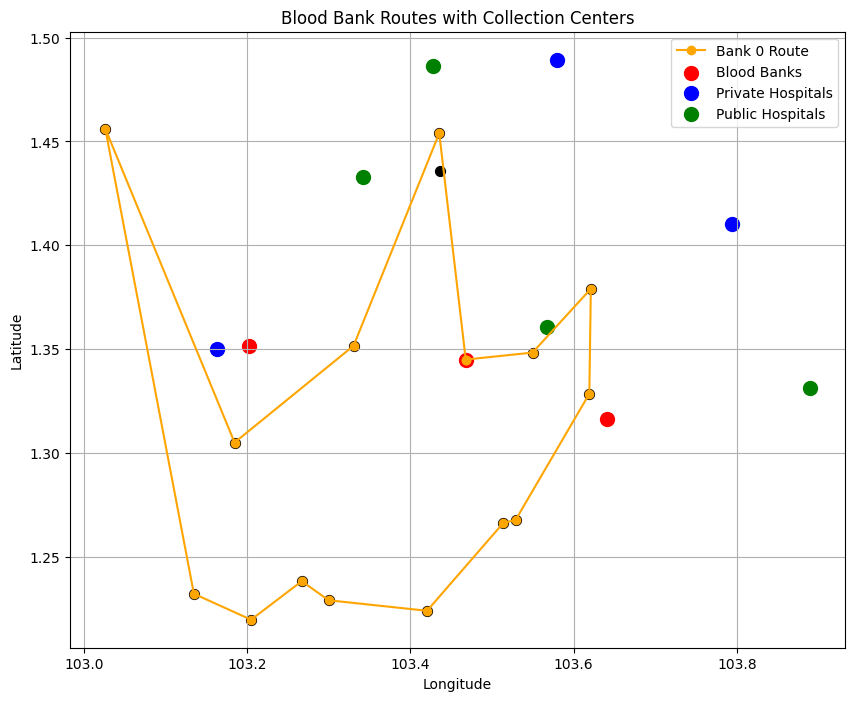

In [7]:
optimal_costs = []
optimal_distances = []
detailed_solutions = []

# Extract TSP routes for each blood bank
def extract_tsp_route(u, k, nbrcomm):
    route = []
    visited = set()
    current = 0  # Start from the first collection center
    while len(route) < nbrcomm - 1:  # nbrcomm - 1 because we start from the first CC
        visited.add(current)
        next_city = None
        for j in range(nbrcomm):
            if j != current and u[k, current, j].X > 0.5 and j not in visited:
                next_city = j
                break
        if next_city is None:
            break  # No more cities to visit
        route.append(next_city)
        current = next_city
    return route
# Plot the routes
plt.figure(figsize=(10, 8))
colors = ['orange', 'green', 'purple', 'brown', 'magenta']
for k in I: # Loop over each blood bank
    if assignments[k]:  # If there are assigned collection centers
        route = extract_tsp_route(u, k, nbrcoll)
        if route:
            path = [bank_coords[k]] + [comm_coords[j] for j in route] + [bank_coords[k]]
            path_x, path_y = zip(*path)
            plt.plot(path_x, path_y, color=colors[k % len(colors)], marker='o', label=f'Bank {k} Route')
            plt.scatter(*zip(*comm_coords), color='black', s=50)  # Collection centers
            plt.scatter(*zip(*bank_coords), color='red', s=100, label='Blood Banks')
            plt.scatter(*zip(*privhosp_coords), color='blue', s=100, label='Private Hospitals')
            plt.scatter(*zip(*pubhosp_coords), color='green', s=100, label='Public Hospitals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Blood Bank Routes with Collection Centers')
plt.legend()
plt.grid()
plt.show()
# Store the optimal solution
optimal_costs.append(model.objVal)
optimal_distances.append(gp.quicksum(x[i, j].X * distancelct[i][j] for i in I for j in J).getValue())
detailed_solutions.append({ 
    'assignments': assignments,
    'x_vals': {var.VarName: var.X for var in model.getVars()},
    'u_vals': {var.VarName: var.X for var in model.getVars() if 'route' in var.VarName},
    'z_vals': {var.VarName: var.X for var in model.getVars() if 'deliver' in var.VarName}
})  